### Recolección de datos y preprocesamiento 

Importamos las librerías necesarias

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Trabajamos con el dataset Caltech101, en su versión 3.0.2.

Extraemos los datos para train, test y la información del dataset

In [3]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101:3.0.2',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    data_dir="data",
    download=False
)

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='data/caltech101/3.0.2',
    file_format=tfrecord,
    download_size=131.05 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    

Guardamos los labels de las clases

In [5]:
class_labels = dataset_info.features['label'].names
class_labels

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'background_google',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'faces',
 'faces_easy',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'leopards',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'motorbikes',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

Esta función nos sirve para normalizar todas las imágenes del dataset.

Hacemos un resize para que las imágenes tengan una dimensión de 224x244px y dividimos para 255 para que los valores estén entre 0 y 1

In [6]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

Procesamos todas las imágenes de nuestro dataset y las mezclamos para evitar que nuestro modelo aprenda memorizando

In [7]:
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

In [8]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Extracción de características

Importamos el modelo VGG16 para extraer las características de las imágenes

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [10]:
# Load the VGG16 model with pretrained weights from ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the feature maps
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

Podemos verificar que el modelo es una CNN y tiene las siguientes capas:

In [11]:
model.layers

Con esta función vamos a extraer las características de cada imagen, su label y el contenido de la imagen

In [12]:
# Function to extract features
def extract_features(dataset):
    features = []
    labels = []
    imgs = []
    for images, lbls in dataset:
        imgs.append(images)
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    return features, labels, imgs

Aplicamos la función en nuestros dataset de train y test

In [13]:
# Extract features for train and test datasets
train_features, train_labels, train_img = extract_features(train_dataset)
test_features, test_labels, test_img = extract_features(test_dataset)

1/1 [==============================] - 0s 499ms/step


### Indexacion

Hacemos un flat a nuestros datasets para reducir sus dimensiones y que tengan el mismo shape que necesita el modelo

In [14]:
# Flatten the feature maps to create feature vectors
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])
train_img_flat = np.array([img for batch in train_img for img in batch])
test_img_flat = np.array([img for batch in test_img for img in batch])

Tenemos 3060 imágenes con 25088 features cada una

In [16]:
train_features_flat.shape

(3060, 25088)

Guardamos nuestros datasets como archivos tipo numpy para poder accederlos en el futuro sin volver a generarlos 

In [17]:
# Optionally, save the features and labels for later use
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels_flat)
np.save('train_img.npy', train_img_flat)
np.save('test_img.npy', test_img_flat)

In [18]:
# Load the saved features and labels
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')
train_img_flat = np.load('train_img.npy')
test_img_flat = np.load('test_img.npy')

### Query

Importamos el modelo NearestNeighbors para recuperar las imágenes relacionadas con nuestra query

In [20]:
# Example query: Retrieve the 5 nearest neighbors for a test image
from sklearn.neighbors import NearestNeighbors

# Fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

Seleccionamos una imagen de nuestro dataset test como query ejemplo

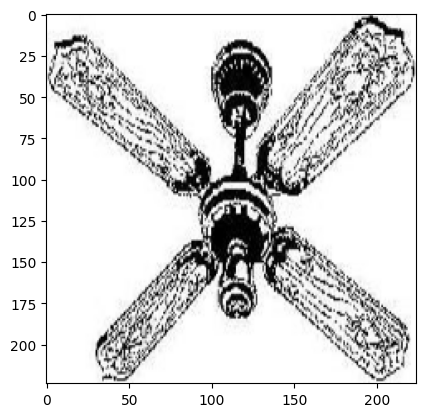

In [30]:
query_image = test_img_flat[5]
query_image = tf.expand_dims(query_image, axis=0)
plt.imshow(query_image[0])

In [31]:
query_image.shape

TensorShape([1, 224, 224, 3])

Extraemos las features de la query

In [32]:
query_features = model.predict([query_image]).flatten().reshape(1, -1)

1/1 [==============================] - 1s 584ms/step


Usando nuestro nearest neighbor model encontramos las distancias y los indices de las imágenes relacionadas a la query

In [33]:
# Find the nearest neighbors
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [[1657 1839 2817  477 2925]]
Distances to nearest neighbors: [[58.59399818 58.79636043 60.79246867 61.21742605 61.68415946]]


Utilizando los indices encontrados, recuperamos las imágenes y los labels correspondientes a las distancias más cercanas

In [37]:
retrieved_images = []
retrieved_labels = []
for indice in indices.flatten():
    retrieved_images.append(train_img_flat[indice])
    retrieved_labels.append(train_labels_flat[indice])

In [40]:
len(retrieved_images)

5

Graficamos las 5 imágenes con mayor relación a nuestra query

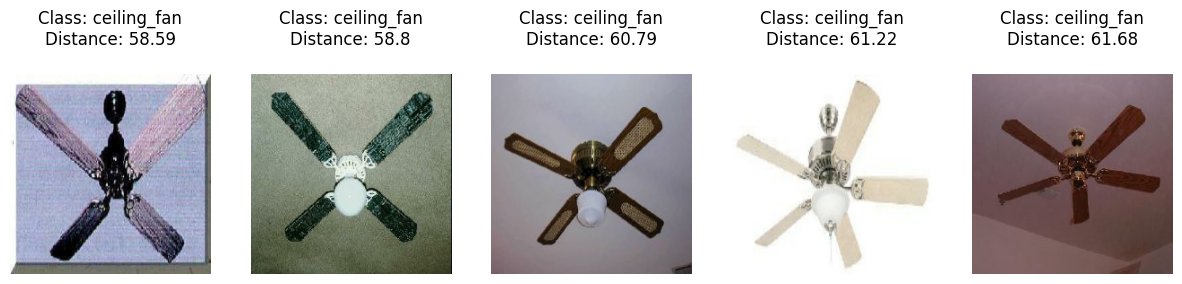

In [43]:
plt.figure(figsize=(15, 3))
for i, image in enumerate(retrieved_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title("Class: " + class_labels[retrieved_labels[i]] + "\nDistance: " + str(
        round(distances[0][i], 2)) + "\n")
    plt.axis('off')
plt.show()